# CineFeel Phase0

- 이 단계에서는 본격적인 프로젝트에 들어가기 앞서, 얼굴 감정분류 관련 데이터셋들을 살펴보는 작업을 진행했습니다.
- 간단한 모델을 설계하여, 데이터셋으로 학습과 평가까지 진행하였습니다.

# 0. 환경설정

## 0.1. 최초 실행 시 기본 학습 데이터셋 준비하기

- Kaggle API를 활용해 데이터셋 가져오기
    - API키는 Google Secret Manager로 관리
- 해당 데이터셋 버킷에 저장

In [ ]:
!pip install kaggle
!pip install google-cloud-storage
!pip install google-cloud-secret-manager

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.1/218.1 kB 4.0 MB/s eta 0:00:00


In [ ]:
# prompt: Kaggle의 FER-2013 데이터 셋을 가져다가 sesac-dl-ljj/pjt_cineFeel 버킷에 저장하고 싶어. 구글 secret manager에서 kaggle-api-key 의 값을 가져와서 kaggle.json으로 사용해줘.

import os
from google.cloud import secretmanager

# Google Cloud Project ID
project_id = "sesac-ljj0210"

# Create a Secret Manager client.
client = secretmanager.SecretManagerServiceClient()

# Access the secret version.
name = f"projects/{project_id}/secrets/kaggle-api-key/versions/latest" # project_id 앞에서 정의했는지 확인
response = client.access_secret_version(request={"name": name})

# kaggle.json 파일 생성
payload = response.payload.data.decode("UTF-8")

with open("kaggle.json", "w") as f:
    f.write(payload)


# kaggle api 설정
os.environ['KAGGLE_CONFIG_DIR'] = "."

# 데이터셋 다운로드
!kaggle datasets download -d msambare/fer2013

# 압축 해제 (fer2013.zip 이라고 가정)
!unzip fer2013.zip



스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating: train/sad/Training_65526454.jpg  
  inflating: train/sad/Training_65531175.jpg  
  inflating: train/sad/Tra

In [ ]:
# 버킷에 업로드
!gsutil -m cp -r fer2013.zip gs://sesac-dl-ljj/pjt_cineFeel

Copying file://fer2013.zip [Content-Type=application/zip]...
- [1/1 files][ 60.3 MiB/ 60.3 MiB] 100% Done                                    
Operation completed over 1 objects/60.3 MiB.                                     


# 1. 데이터 분석 및 전처리

## 1.1. 파일 분석

In [ ]:
!ls

fer2013.zip  test  train


In [ ]:
# prompt: unzip된 test, train 데이터 폴더와 디렉토리 구조, 이미지 파일의 특성들을 확인해서 데이터셋으로 만들고 싶어

import os
from PIL import Image
import matplotlib.pyplot as plt

# train, test 폴더 경로
train_dir = "train"
test_dir = "test"


def analyze_dataset(data_dir):
  """
  데이터셋의 디렉토리 구조, 이미지 파일 특성 등을 분석합니다.
  """
  for emotion_folder in os.listdir(data_dir):
    emotion_path = os.path.join(data_dir, emotion_folder)
    print(f"Emotion: {emotion_folder}")
    print(f"Number of images: {len(os.listdir(emotion_path))}")

    # 이미지 파일 특성 분석 (첫 번째 이미지 예시)
    sample_image_path = os.path.join(emotion_path, os.listdir(emotion_path)[0])
    try:
      img = Image.open(sample_image_path)
      print(f"  Sample image size: {img.size}")
      print(f"  Sample image mode: {img.mode}")
      # 이미지 출력 (선택)
      # plt.imshow(img)
      # plt.title(f"Sample image from {emotion_folder}")
      # plt.show()

    except Exception as e:
      print(f"Error opening image: {e}")
    print("-" * 20)


# train 데이터 분석
print("Analyzing Train Data:")
analyze_dataset(train_dir)

# test 데이터 분석
print("\nAnalyzing Test Data:")
analyze_dataset(test_dir)

Analyzing Train Data:
Emotion: fear
Number of images: 4097
  Sample image size: (48, 48)
  Sample image mode: L
--------------------
Emotion: surprise
Number of images: 3171
  Sample image size: (48, 48)
  Sample image mode: L
--------------------
Emotion: sad
Number of images: 4830
  Sample image size: (48, 48)
  Sample image mode: L
--------------------
Emotion: happy
Number of images: 7215
  Sample image size: (48, 48)
  Sample image mode: L
--------------------
Emotion: disgust
Number of images: 436
  Sample image size: (48, 48)
  Sample image mode: L
--------------------
Emotion: neutral
Number of images: 4965
  Sample image size: (48, 48)
  Sample image mode: L
--------------------
Emotion: angry
Number of images: 3995
  Sample image size: (48, 48)
  Sample image mode: L
--------------------

Analyzing Test Data:
Emotion: fear
Number of images: 1024
  Sample image size: (48, 48)
  Sample image mode: L
--------------------
Emotion: surprise
Number of images: 831
  Sample image siz

## 1.2. Dataset화

In [ ]:
# prompt: train에 있는 데이터와 test에 있는 데이터를 image from directory를 이용해서 dataset화 하고 싶어. keras를 이용할 건데, tf와 keras는 분리해서 import한뒤 사용하자. train 데이터의 일부는 검증용 데이터로 사용할거야. 8:2로 나누자. 그리고 원 핫 인코딩을 사용해

import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import numpy as np
import collections

# 이미지 크기 설정
img_height = 48
img_width = 48

# 검증 데이터 비율
val_split = 0.2

# 훈련데이터
train_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=val_split,
    subset="training",
    seed=123,  # 고정 시드로 split consistency 유지
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=32,
    shuffle=True
)

# 검증 데이터
val_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=val_split,
    subset="validation",
    seed=123,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=32,
    shuffle=True
)

# test 데이터셋 생성
test_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=32,
    shuffle=False # test data는 shuffle하지 않음
)
# 클래스 이름 확인 (분할 전에 저장)
class_names = train_ds.class_names

def count_per_class(dataset):
    labels = []
    for _, ys in dataset.unbatch():
        labels.append(tf.argmax(ys).numpy())
    return dict(collections.Counter(labels))

print("Train label distribution:", count_per_class(train_ds))
print("Validation label distribution:", count_per_class(val_ds))
print("Test label distribution:", count_per_class(test_ds))


Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.
Train label distribution: {np.int64(2): 3287, np.int64(5): 3852, np.int64(4): 3924, np.int64(0): 3230, np.int64(3): 5807, np.int64(6): 2526, np.int64(1): 342}
Validation label distribution: {np.int64(5): 978, np.int64(6): 645, np.int64(4): 1041, np.int64(3): 1408, np.int64(2): 810, np.int64(0): 765, np.int64(1): 94}
Test label distribution: {np.int64(0): 958, np.int64(1): 111, np.int64(2): 1024, np.int64(3): 1774, np.int64(4): 1233, np.int64(5): 1247, np.int64(6): 831}


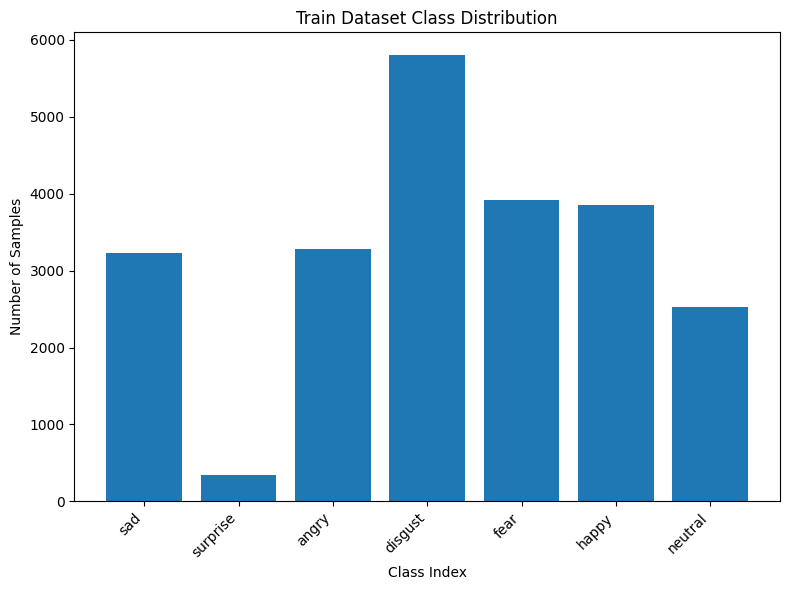

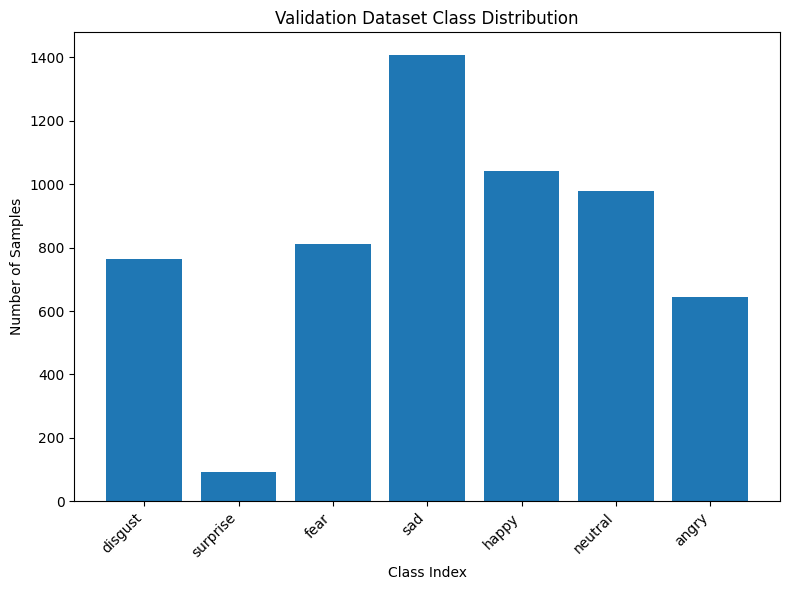

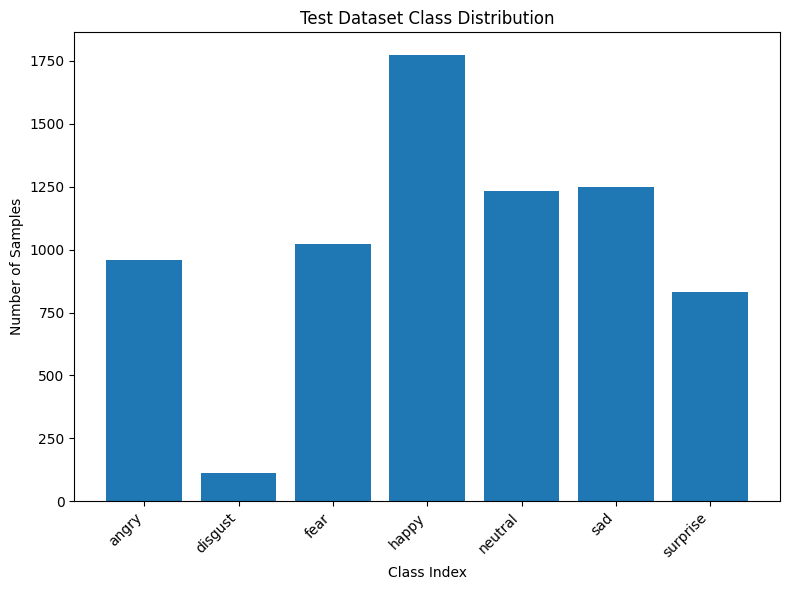

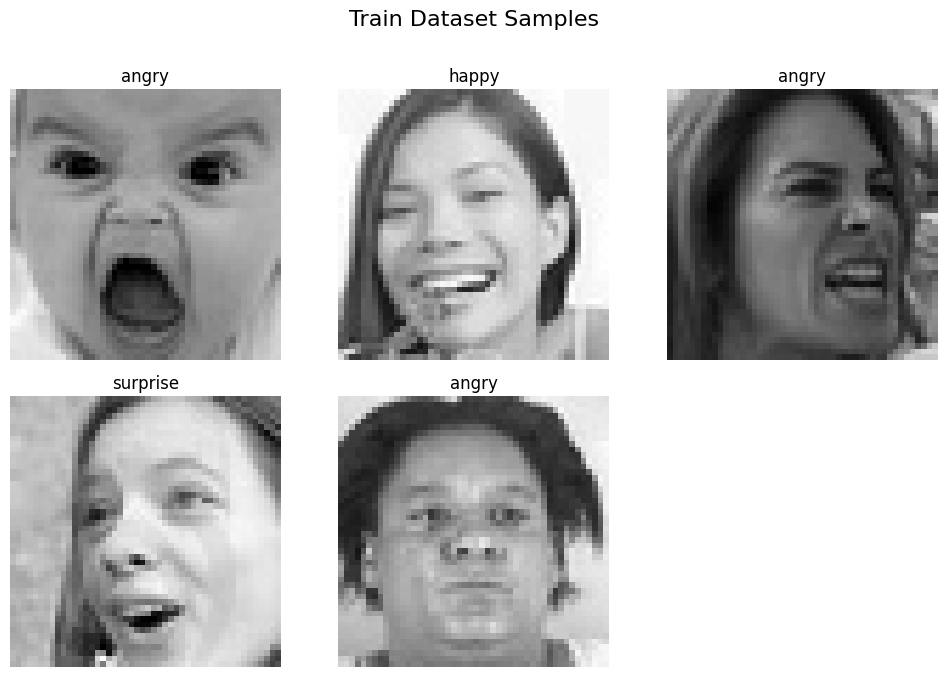

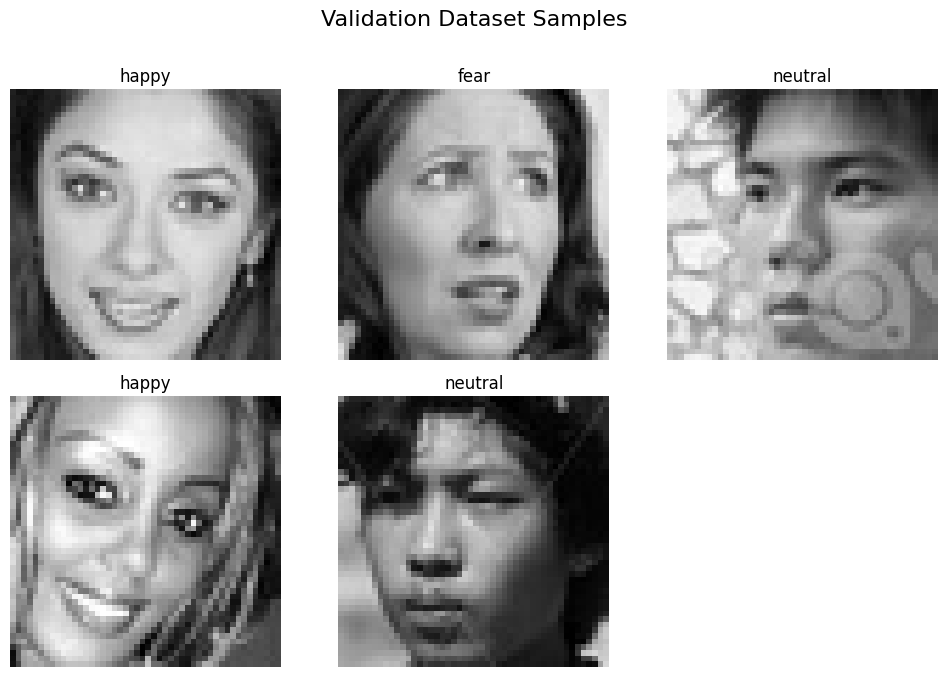

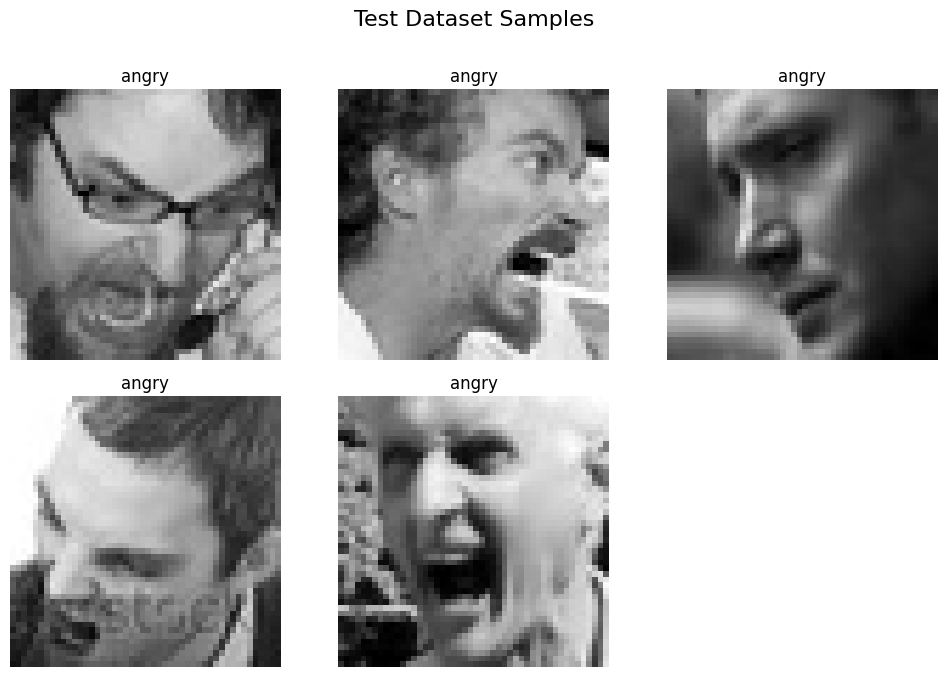

In [ ]:
# prompt: 각 데이터셋별로 분류를 시각화하는 코드를 짜줘. subplot을 이용해서 깔끔하게

import numpy as np
import matplotlib.pyplot as plt

def visualize_class_distribution(dataset, title):
  """
  데이터셋의 클래스 분포를 시각화합니다.
  """
  counts = count_per_class(dataset)
  labels = list(counts.keys())
  values = list(counts.values())

  plt.figure(figsize=(8, 6))
  plt.bar(labels, values)
  plt.xlabel("Class Index")
  plt.ylabel("Number of Samples")
  plt.title(title)
  plt.xticks(labels, class_names, rotation=45, ha='right') # x축 레이블을 클래스 이름으로 설정
  plt.tight_layout() # 레이블이 겹치지 않도록 조정
  plt.show()


# 각 데이터셋 시각화
visualize_class_distribution(train_ds, "Train Dataset Class Distribution")
visualize_class_distribution(val_ds, "Validation Dataset Class Distribution")
visualize_class_distribution(test_ds, "Test Dataset Class Distribution")


def visualize_samples(dataset, title, num_samples=5):
  """
  데이터셋에서 샘플 이미지를 시각화합니다.
  """
  plt.figure(figsize=(10, 10))
  plt.suptitle(title, fontsize=16) # 전체 제목 추가
  for images, labels in dataset.take(1):
    for i in range(num_samples):
      ax = plt.subplot(3, 3, i + 1) # subplot 위치 조정
      plt.imshow(images[i].numpy().astype("uint8"))
      label_index = np.argmax(labels[i])
      plt.title(class_names[label_index])
      plt.axis("off")
  plt.tight_layout() # subplot 간격 조정
  plt.subplots_adjust(top=0.9) # 전체 제목과 subplot 간격 조정
  plt.show()

# 각 데이터셋에서 샘플 이미지 시각화
visualize_samples(train_ds, "Train Dataset Samples")
visualize_samples(val_ds, "Validation Dataset Samples")
visualize_samples(test_ds, "Test Dataset Samples")

# 2. 모델 설계

In [ ]:
from keras import layers, models, Input

model = models.Sequential([
    Input(shape=(48, 48, 3)),
    layers.Rescaling(1./255),                                  # 1. 정규화

    layers.Conv2D(32, (3, 3), activation='relu'),              # 2. 첫 번째 특징 추출
    layers.MaxPooling2D((2, 2)),                               # 3. 공간 크기 줄이기

    layers.Conv2D(64, (3, 3), activation='relu'),              # 4. 더 깊은 특징 추출
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),             # 5. 더 복잡한 특징 인식
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),                                          # 6. CNN → MLP 변환
    layers.Dense(128, activation='relu'),                      # 7. Fully connected layer
    layers.Dropout(0.5),                                       # 8. 과적합 방지용 Dropout
    layers.Dense(7, activation='softmax')                      # 9. 감정 클래스 7개
],name="cineFeel_cnn_practice")

model.summary()

Model: "cineFeel_cnn_practice"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 46, 46, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,423 (1.36 MB)

 Trainable params: 356,423 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# prompt: cineFeel_cnn_practice 모델을 컴파일 하자

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 3. 모델 학습

Epoch 1/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 42s 56ms/step - accuracy: 0.2505 - loss: 1.8026 - val_accuracy: 0.3822 - val_loss: 1.5809
Epoch 2/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 40s 55ms/step - accuracy: 0.4023 - loss: 1.5457 - val_accuracy: 0.4593 - val_loss: 1.4107
Epoch 3/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 39s 54ms/step - accuracy: 0.4689 - loss: 1.3997 - val_accuracy: 0.5010 - val_loss: 1.3154
Epoch 4/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 39s 54ms/step - accuracy: 0.4956 - loss: 1.3187 - val_accuracy: 0.5238 - val_loss: 1.2570
Epoch 5/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 36s 50ms/step - accuracy: 0.5291 - loss: 1.2405 - val_accuracy: 0.5381 - val_loss: 1.2315
Epoch 6/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 36s 50ms/step - accuracy: 0.5514 - loss: 1.1775 - val_accuracy: 0.5407 - val_loss: 1.2204
Epoch 7/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 39s 54ms/step - accuracy: 0.5741 - loss: 1.1212 - val_accuracy: 0.5515 - val_loss: 1.2227
Epoch 8/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 39s 54ms/step - accuracy: 0.5876 - loss: 1.0752 - 

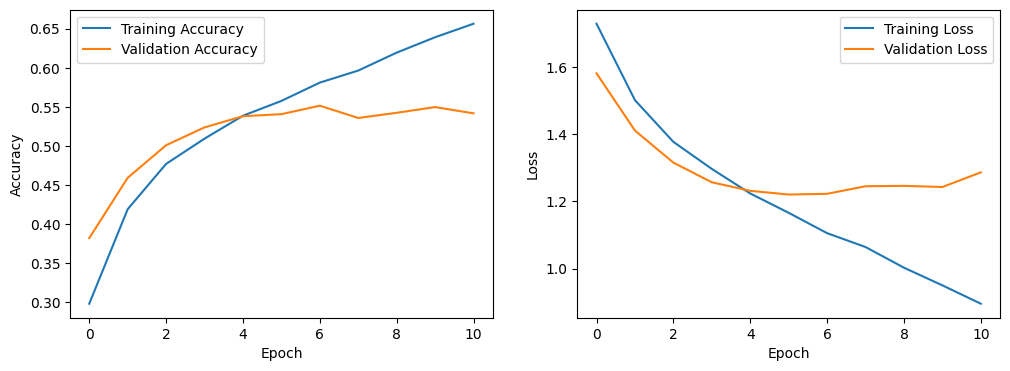

In [ ]:
# prompt: 컴파일된 모델로 학습을 진행하자. 학습이 완료된 후에는 history를 시각화하자

# 조기 종료 콜백 설정
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # 검증 손실 모니터링
    patience=5,           # 5 epoch 동안 개선 없으면 종료
    restore_best_weights=True # 가장 좋은 가중치 복원
)

# 모델 학습
epochs = 30
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping]
)

# 학습 결과 시각화
import matplotlib.pyplot as plt

def plot_history(history):
  """
  모델 학습 history를 시각화합니다.
  """
  plt.figure(figsize=(12, 4))

  # Accuracy 그래프
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  # Loss 그래프
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()


plot_history(history)

# 4. 모델 평가

In [ ]:
# prompt: 해당 모델을 평가하자

loss, accuracy = model.evaluate(test_ds)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.4943 - loss: 1.2941
Test Loss: 1.1995859146118164
Test Accuracy: 0.5394260287284851


### 저장은 정확도가 너무 낮아 생략함

# 기타

- AI hub의 [한국인 감정인식을 위한 복합 영상(링크)](https://www.aihub.or.kr/aihubdata/data/view.do?pageIndex=3&currMenu=&topMenu=&srchOptnCnd=OPTNCND001&searchKeyword=%ED%91%9C%EC%A0%95&srchDetailCnd=DETAILCND001&srchOrder=ORDER001&srchPagePer=20&aihubDataSe=data&dataSetSn=82) 데이터셋

![예시이미지](https://aihub.or.kr/web-nas/aihub21/files/public/inline-images/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-06-14%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%206.45.06_0.png
)

  - 이미 학습까지 된 모델이 있으나, 데이터셋을 확인했을 때 영화의 인물들을 분석하기에는 적절하지 않다고 판단.
    -  데이터셋 전부 셀카(selfie)형식
    -  배경 정보도 학습에 사용함